In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods, txtbox512
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import time
slim = tf.contrib.slim
import load_batch
import numpy as np
import skimage.io as skio
from processing import tf_image
import cv2
import matplotlib.pylab as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
isess = tf.InteractiveSession()

In [81]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    #print [ymin,xmin,ymax,xmax]
    plt.imshow(image)
    plt.show()

In [ ]:
anchor_sizes=[(30., 60.),
          (60., 114.),
          (114., 168.),
          (168., 222.),
          (222., 276.),
          (276., 330.)]
anchor_sizes=[(21., 51.),
              (51., 99.),
              (133., 153.),
              (215., 207.),
              (296., 261.),
              (379., 315.),
              (461, 543.)]
scale_range=[0.05, 0.75]
scale_range_max = [0.1, 0.9]
scales = [scale_range[0] + i*(scale_range[1] - scale_range[0])/6  for i in range(7)]
scales_max = [scale_range_max[0] + i*(scale_range_max[1] - scale_range_max[0])/6  for i in range(7)]
anchor_sizes = [(512*scales[i], 512*scales_max[i]) for i in range(7)]
anchor_sizes=[(30., 51.),
              (60., 99.),
              (114., 153.),
              (168., 207.),
              (222., 261.),
              (276., 315.)]

anchor_sizes



text_shape (300, 300)
0.5
file_path: ../data/ICDAR2013/*.tfrecord


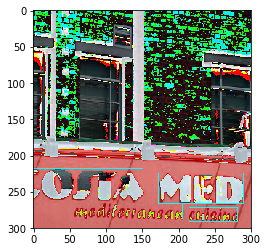

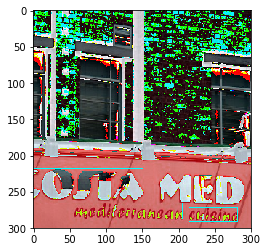

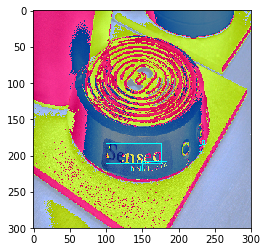

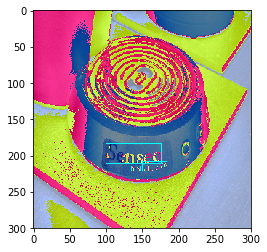

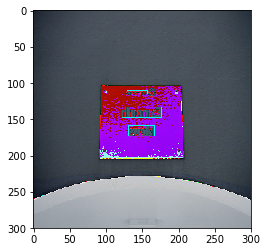

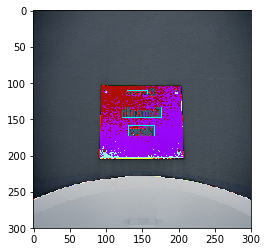

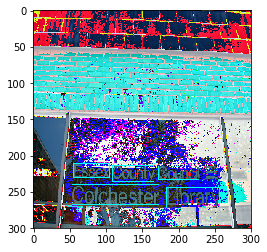

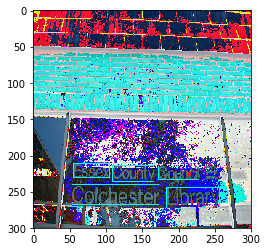

92
{1: array([[[ 0.70520836,  0.18437499,  0.76979166,  0.35078126],
        [ 0.71145833,  0.36406249,  0.78854167,  0.55546874],
        [ 0.71562499,  0.57343757,  0.77812499,  0.76328123],
        ..., 
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]], dtype=float32)}
3.0


In [102]:
out_shape = [500,700]
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox_300.TextboxNet.default_params
    #params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox_300.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)
    b_gdifficults = tf.zeros(tf.shape(glabels), dtype=tf.int64)
    #image = (dst_image - tf.reduce_min(dst_image))/ (tf.reduce_max(dst_image) - tf.reduce_min(dst_image))
    glocalisations, gscores = \
    text_net.bboxes_encode( gbboxes, text_anchors, num)
    logits = []
    predictions = []
    for i in range(6):
        glocalisations[i] = tf.expand_dims(glocalisations[i], axis=0)
        gscores[i] = tf.expand_dims(gscores[i], axis=0)
        logits.append(tf.cast(gscores[i] > 0.5, tf.int32))
        predictions.append(tf.one_hot(logits[i],axis=-1,depth=2,off_value=0.0,on_value=1.0))
    localisations = text_net.bboxes_decode(glocalisations, text_anchors)
    rscores, rbboxes = \
    text_net.detected_bboxes(predictions, localisations,
                            select_threshold=0.01,
                            nms_threshold=0.5,
                            clipping_bbox=None,
                            top_k=400,
                            keep_top_k=400)

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            error = []
            box = []
            ws = []
            hs = []
            sum0 = 0
            for i in xrange(4):
                rpredictions, rlocalisations, img ,gbboxes_, pre_box_= \
                                        sess.run([gscores, glocalisations,dst_image,gbboxes,rbboxes])
                #num_boxes, tp_, fp_, rscores_ = sess.run([num_gbboxes, tp, fp, rscores])
                
                for i in range(6):
                    sum0 += np.sum(rpredictions[i] > 0.5)
                error.append(gbboxes_.shape[0] - np.ceil(np.sum(pre_box_[1][0] > 0) /4.))
                #img = img * 255
                image_ = img.astype(np.uint8)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                img_ = image_.copy()
                visualize_bbox(img_, pre_box_[1][0])
            print sum0
            print pre_box_
            print np.sum(error)
            

In [95]:
r = tf.random_uniform([1], minval=0, maxval=10, dtype=tf.int32, seed=None, name=None)
isess.run(r[0])

2

In [98]:
tf.constant(0)

<tf.Tensor 'Const_3:0' shape=() dtype=int32>

In [93]:


y = tf.constant([1])
condition = tf.equal(x, y)
indices = tf.where(condition)
print isess.run(indices[0])
indice = [indices[0]] 
values =[1.]
shape = x.shape
delta = tf.SparseTensor(indice, values, shape)
c0 = tf.zeros_like(x_num, tf.float32)
fmask = c0 + tf.sparse_tensor_to_dense(delta)
np.where(isess.run(fmask) == 1)


NameError: name 'x' is not defined

file_path: ../data/ICDAR2013/*.tfrecord
{'global': <tf.Tensor 'text_box_300/global/conv3x3/Relu:0' shape=(1, 1, 1, 256) dtype=float32>, 'conv3': <tf.Tensor 'text_box_300/conv3/conv3_3/Relu:0' shape=(1, 75, 75, 256) dtype=float32>, 'conv2': <tf.Tensor 'text_box_300/conv2/conv2_2/Relu:0' shape=(1, 150, 150, 128) dtype=float32>, 'conv1': <tf.Tensor 'text_box_300/conv1/conv1_2/Relu:0' shape=(1, 300, 300, 64) dtype=float32>, 'conv10': <tf.Tensor 'text_box_300/conv10/conv3x3/Relu:0' shape=(1, 3, 3, 256) dtype=float32>, 'conv7': <tf.Tensor 'text_box_300/conv7/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv6': <tf.Tensor 'text_box_300/conv6/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv5': <tf.Tensor 'text_box_300/conv5/conv5_3/Relu:0' shape=(1, 19, 19, 512) dtype=float32>, 'conv4': <tf.Tensor 'text_box_300/conv4/conv4_3/Relu:0' shape=(1, 38, 38, 512) dtype=float32>, 'conv9': <tf.Tensor 'text_box_300/conv9/conv3x3/Relu:0' shape=(1, 5, 5, 256) dtype=float32>, 'conv8': <tf.Tensor 't

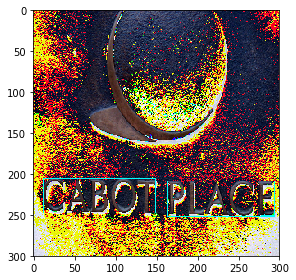

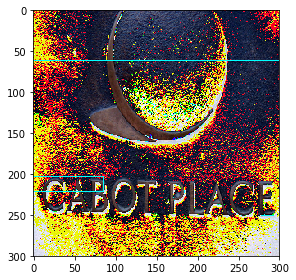

In [70]:
DATA_FORMAT = 'NHWC'
with tf.Graph().as_default(): 
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    text_anchors = text_net.anchors(text_shape)
    #print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    image, glabels, gbboxes,bbox_img, num = \
    txt_preprocessing.preprocess_image(image, glabels,gbboxes, 
                                            text_shape,is_training=False)
    
    glocalisations, gscores = \
        text_net.bboxes_encode( gbboxes, text_anchors, num)

    b_image, glabels, b_gbboxes, g_bbox_img, b_glocalisations, b_gscores  = \
        [tf.expand_dims(image, 0),tf.expand_dims(glabels, 0), tf.expand_dims(gbboxes, 0), bbox_img,b_glocalisations, b_gscores]
    #b_image = tf.expand_dims(b_image, 0)
    b_gdifficults = tf.zeros(tf.shape(glabels), dtype=tf.int64)
    dict_metrics = {}
    arg_scope = text_net.arg_scope(data_format=DATA_FORMAT)
    with slim.arg_scope(arg_scope):
        localisations, logits, end_points  = \
            text_net.net(b_image, is_training=False, use_batch=True, reuse=None)

    predictions = []
    for i in range(len(logits)):
        predictions.append(tf.nn.softmax(logits[i]))

    localisations = text_net.bboxes_decode(localisations, text_anchors)
    rscores, rbboxes = \
        text_net.detected_bboxes(predictions, localisations,
                                select_threshold=0.5,
                                nms_threshold=0.45,
                                clipping_bbox=None,
                                top_k=400,
                                keep_top_k=200)

    num_gbboxes, tp, fp, rscores = \
        tfe.bboxes_matching_batch(rscores.keys(), rscores, rbboxes,
                                  glabels, b_gbboxes, b_gdifficults,
                                  matching_threshold=0.5)
    dict_metrics = {}
    dtype = tf.float32
    tp = tf.reduce_sum(tf.cast(tp[1], dtype))
    fp = tf.reduce_sum(tf.cast(fp[1], dtype))
    recall =tf.div(tp, tf.cast(num_gbboxes[1], tf.float32))
    precision = tf.div(tp, tp + fp)

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, '../checkpoints/model.ckpt-182167')
        #print tf.all_variables()
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                num_gbboxes_, tp_, fp_, rscores_,gbboxes_,image_,pre_box_,glabels_,predictions_,pre,rec= \
                        sess.run([num_gbboxes, tp, fp, rscores,
                                 gbboxes,image,rbboxes,glabels,predictions,precision,recall])
                print image_.shape
                img = image_ 
                image_ = img.astype(np.uint8)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                img_ = image_.copy()
                visualize_bbox(img_, pre_box_[1][0])
  

In [65]:
print b_image.shape
for i in range(6):
    print np.sum(predictions_[i][:,:,:,:,:,1]>0.5)

(1, 300, 300, 3)
19
47
0
9
3
1


In [72]:
#print np.sum(tp_[1]), np.sum(fp_[1])
print pre,rec

0.0 [ 0.]


In [73]:
tp_[1]

IndexError: invalid index to scalar variable.